In [ ]:
# coding: utf-8

# In[ ]:
import sys, os
sys.path.insert(0, '..')
from lib import models, graph, coarsening, utils
import numpy as np
import time
from nips2016 import humantraffic
from tensorflow.python import debug as tf_debug
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import math
# 配置显存大小
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.8)
sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))


# In[ ]:

flags = tf.app.flags
FLAGS = flags.FLAGS

# Graphs.
flags.DEFINE_integer('number_edges', 8, 'Graph: minimum number of edges per vertex.')
flags.DEFINE_string('metric', 'euclidean', 'Graph: similarity measure (between features).')
# TODO: change cgcnn for combinatorial Laplacians.
flags.DEFINE_bool('normalized_laplacian', True, 'Graph Laplacian: normalized.')
flags.DEFINE_integer('coarsening_levels', 4, 'Number of coarsened graphs.')

# Directories.
flags.DEFINE_string('dir_data', os.path.join('..', 'data', 'mnist'), 'Directory to store data.')

In [ ]:
print('current path is {0}'.format(os.getcwd()))

In [ ]:
# In[ ]:

def grid_graph(m, corners=False):
    z = graph.grid(m)
    dist, idx = graph.distance_sklearn_metrics(z, k=FLAGS.number_edges, metric=FLAGS.metric)
    A = graph.adjacency(dist, idx)

    # Connections are only vertical or horizontal on the grid.
    # Corner vertices are connected to 2 neightbors only.
    if corners:
        import scipy.sparse
        A = A.toarray()
        A[A < A.max()/1.5] = 0
        A = scipy.sparse.csr_matrix(A)
        print('{} edges'.format(A.nnz))

    print("{} > {} edges".format(A.nnz//2, FLAGS.number_edges*m**2//2))
    return A

t_start = time.process_time()
A = grid_graph(20, corners=False)
# A = graph.replace_random_edges(A, 0)
# graphs, perm = coarsening.coarsen(A, levels=FLAGS.coarsening_levels, self_connections=False)
L = [graph.laplacian(A, normalized=True)] # [graph.laplacian(A, normalized=True) for A in graphs]
print('Execution time: {:.2f}s'.format(time.process_time() - t_start))
# graph.plot_spectrum(L)
del A

In [ ]:
node_count = 20 * 20
t_start = time.process_time()
ht = humantraffic.HumanTraffic()
seq_num = 3
train_data, val_data, test_data, train_labels, val_labels, test_labels, A = ht.load_data(seq_num)
# L = [graph.laplacian(A, normalized=True)] # [graph.laplacian(A, normalized=True) for A in graphs]
# del A
train_data_ = np.zeros((train_data.shape[0], train_data.shape[1], train_data.shape[2]))
print('Execution time: {:.2f}s'.format(time.process_time() - t_start))

(1334, 400, 2)


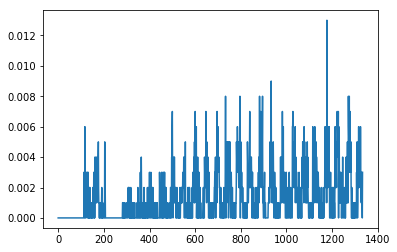

In [12]:
print(train_labels.shape)
plt.plot(train_labels[:, 50, 0])

(1334, 400, 6)
NN architecture
  input: M_0 = 400
  layer 1: cgconv1
    representation: M_0 * F_1 / p_1 = 400 * 10 / 1 = 4000
    weights: F_0 * F_1 * K_1 = 1 * 10 * 5 = 50
    biases: F_1 = 10
  layer 2: logits (softmax)
    representation: M_2 = 400
    weights: M_1 * M_2 = 4000 * 400 = 1600000
    biases: M_2 = 400
dict_keys(['conv_init/weights:0', 'conv_init/filter/transpose_2:0', 'conv_init/bias:0', 'conv_init/activation/Relu:0', 'residual_layer_0/sublayer0/weights:0', 'residual_layer_0/sublayer0/bias:0', 'residual_layer_0/sublayer1/weights:0', 'residual_layer_0/sublayer1/bias:0', 'residual_layer_0/merge/add:0', 'residual_layer_1/sublayer0/weights:0', 'residual_layer_1/sublayer0/bias:0', 'residual_layer_1/sublayer1/weights:0', 'residual_layer_1/sublayer1/bias:0', 'residual_layer_1/merge/add:0', 'residual_layer_2/sublayer0/weights:0', 'residual_layer_2/sublayer0/bias:0', 'residual_layer_2/sublayer1/weights:0', 'residual_layer_2/sublayer1/bias:0', 'residual_layer_2/merge/add:0', 'r

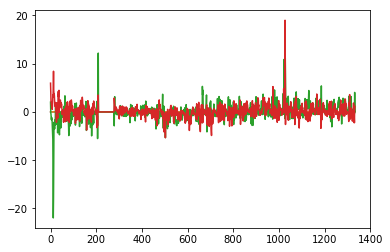

train finish~


In [13]:
# In[ ]:
common = {}
common['dir_name']       = 'mnist/'
common['num_epochs']     = 200
common['batch_size']     = 200
common['decay_steps']    = train_data.shape[0] / common['batch_size']
common['eval_frequency'] = 100
common['brelu']          = 'b1relu'
common['pool']           = 'mpool1'
# C = max(mnist.train.labels) + 1  # number of classes
model_perf = utils.model_perf()
print(train_data.shape)
# Common hyper-parameters for networks with one convolutional layer.
common['regularization'] = 0
common['dropout']        = 1
common['learning_rate']  = 0.01
common['decay_rate']     = 0.95
common['momentum']       = 0.9
common['F']              = [10]
common['K']              = [20]
common['p']              = [1]
common['M']              = [node_count]

# In[ ]:

if True:
    name = 'fgconv_softmax'
    params = common.copy()
    params['dir_name'] += name
    # params['filter'] = 'chebyshev5' # fourier
    params['filter'] = 'fourier'
    params['K'] = [5]
    params['C_0'] = seq_num * 2
    train_pred, test_pred =  model_perf.test(models.cgcnn(L, **params), name, params,
                    train_data, train_labels, val_data, val_labels, test_data, test_labels)

    train_pred, test_pred = ht.reverse_normalize(train_pred), ht.reverse_normalize(test_pred)
    train_target, test_target = ht.reverse_normalize(train_labels), ht.reverse_normalize(test_labels)
    #
    # real_data = np.concatenate(train_labels, test_labels)
    # pred_data = np.concatenate(train_pred, test_pred)
    print(str(math.sqrt(np.sum((train_target - train_pred) ** 2) / (train_pred.shape[0] * train_pred.shape[1] * train_pred.shape[2]))))
    print(str(math.sqrt(np.sum((test_target - test_pred) ** 2) / (test_pred.shape[0] * test_pred.shape[1] * test_pred.shape[2]))))
    print('train finish...\n')

In [ ]:
print(train_target.shape)
print(train_labels.shape)

In [ ]:
print(train_pred.shape)

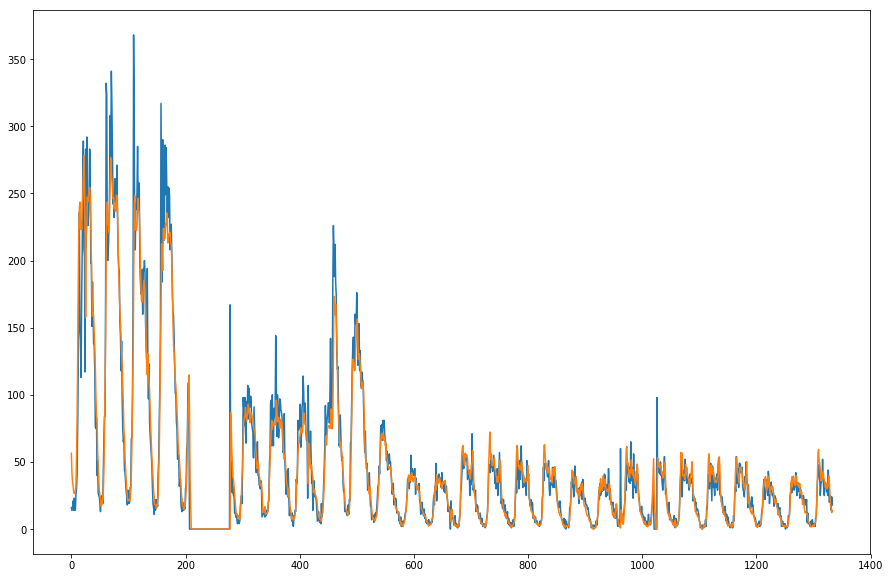

In [37]:
fig = plt.figure()
fig.set_size_inches(15, 10)
plt.plot(train_target[:, 68, 1])
plt.plot(train_pred[:, 68, 1])

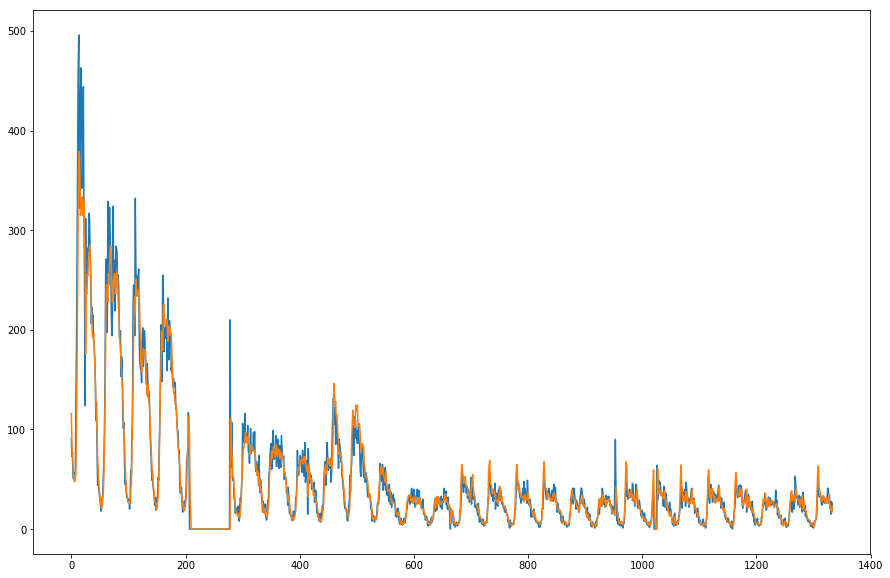

In [39]:
fig = plt.figure()
fig.set_size_inches(15, 10)
plt.plot(train_target[:, 68, 0])
plt.plot(train_pred[:, 68, 0])